# Начало главы 8: Генеративное глубокое обучение

В данном ноутбуке представлены примеры:

1) Посимвольной генерации текста

Последовательности данных генерируются сетями, которые по предыдущим токенам укатся генерировать следующие

В модель передается начальная строка - конлиционные данные, после чего она их обрабатывает и возвращает новые токены. Они добавляются к старым и полученный результат снова помещается в модель. *Это языковая модель уровня символов.*


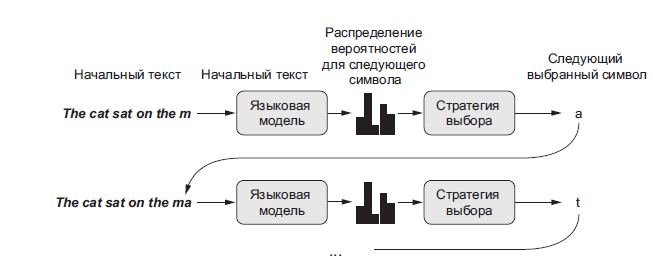

Важным элементом является стратегия выбора следующего токена:

1) Жадный выбор - токен с наибольшей вероятностью

2) Стохастический выбор - если у символа "а" вероятность 30%, то его выберем в 3ех случаях из 10. Обычно такой выбор делается из вектора softmax. Так как в нем есть некоторая энтропия распределения вероятностей следующих токенов. 

Меньшая энтропия распределения вероятностей следующих токенов позволяет сети сделать более предсказуемый и логический (с точки зрения человека) выбор. А при большей вероятности сеть будет делать более неожиданные выборы. 

Введем *температуру softmax*. Чем она выше - тем больше энтропия. 


# Посимвольная генерация текста на основе LSTM

Парсинг текста произведений Ницше

In [ ]:
import keras
import numpy as np

path =  keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt'
)
text = open(path).read().lower()
print(f'Text length is {len(text)}')



Text length is 600893


# Векторизация последовательностей символов

In [ ]:
# извлечем последовательности длиной maxlen, сделаем one-hot encoding, 
# упакуем в массив (число последовательностей, максимальная длина, количество уникальных символов)
# так же получим цели - векторное представление букв, которые идут прямо за извлеченными последовательностями
# типа погода -> (пого)(д) здесь д - цель

maxlen = 60
# новые последовательности выбираются через каждые 3 символа
step = 3
# хранилище предложений
sentences = []
# цели
next_chars = []

for i in range(0, len(text)-maxlen, step):
  sentences.append(text[i : i + maxlen])
  next_chars.append(text[i + maxlen])

print(f'number of sequences is {len(sentences)}')

# уникальные символы в тексте
chars = sorted(list(set(text)))
print(f'number of unique characters is {len(chars)}')
# словарь: символ - индекс в массиве уникальных символов
char_indices = dict((char, chars.index(char)) for char in chars)

print('Vectorization...')
# принимают значения 1 или 0 (просто по-хитрому написано)
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

# one-hot encoding
for i, sentence in enumerate(sentences):
  for j, char in enumerate(sentence):
    # одному символу соответствует 1, а все остальные - 0
    x[i, j, char_indices[char]] = 1
  y[i, char_indices[next_chars[i]]] = 1


number of sequences is 200278
number of unique characters is 57
Vectorization...


# Конструирование сети

In [ ]:
from keras.layers import LSTM, Dense
from keras.models import Sequential

model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
# в слое столько нейронов, сколько уникалтных символов в тексте, потому что он
# возвращает вероятность каждого символа
model.add(Dense(len(chars), activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')


Имея обученную модель и фрагмент начального текста, можно сгенерировать новый текст, выполнив следующие пункты:

* Извлечь из модели распределение вероятностей следующего символа для имеющегося на данный момент сгенерированного текста.

* Выполнить взвешивание распределения с заданной температурой.

* Выбрать следующий символ в соответствии с вновь взвешенным распределением вероятностей.

* Добавить новый символ в конец текста.

# Функция выборки слудующего символа с учетом предыдущего и температуры softmax

In [ ]:
def get_next_index(preds, temperatur=1.0):
  preds = np.asarray(preds).astype('float64')
  # повторное взвешивание по температуре - изменение энтропии
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  # распределение вероятностей (нормальное) только в трехмерном пространстве
  probs = np.random.multinomial(1, preds, 1)
  return np.argmax(probs)

# Цикл генерации текста

In [ ]:
# для начала сгенерируем текст с разной температурой после каждой эпохи

import random
import sys

for epoch in range(1, 60):
  print(f'\n-------------------- epoch {epoch} --------------------')
  # выполнение одной итерации обучения
  model.fit(x, y, batch_size=128, epochs=1)
  # выбирается случаное положение в тексте
  start_index = random.randint(0, len(text) - maxlen - 1)
  # выбор случайного начального текста
  generated_text = text[start_index: start_index + maxlen]
  print(f'\n----Generating with random text "{generated_text}"')
  # возьмем для наглядности две сильно отличающиеся температуры
  for temperature in [0.2, 1.2]:
    print(f'\n----temperature {temperature}')
    sys.stdout.write(generated_text)
    # генерация 400 символов, начиная с конца случайного текста
    for i in range(400):
      # прямое кодирование текста, полученного до сих пор
      sampled = np.zeros((1, maxlen, len(chars)))
      for t, char in enumerate(generated_text):
        sampled[0, t, char_indices[char]] = 1.
      # выбор следующего символа
      preds = model.predict(sampled, verbose=0)[0]
      next_index = get_next_index(preds, temperature)
      next_char = chars[next_index]

      # добавление символа в текст
      generated_text += next_char
      generated_text = generated_text[1:]

      # то же самое, что и print (?)
      sys.stdout.write(next_char)

      




-------------------- epoch 1 --------------------
1565/1565 [==============================] - 10s 6ms/step - loss: 1.4176

----Generating with random text "erhaps a flush of shame for what they did and at the same
ti"

----temperature 0.2
erhaps a flush of shame for what they did and at the same
time for the sense of the are of the sense of the sense of the
same and sense it is also the sense of the sense of a still of the
same and the sense of the sense of the spirit as the sense of the
same and complesence of the spirit as in the belief the sense of the sense of the
since of the sense of the spirit and the sense of the spirit as the
same than the world of the sense of the self-contention 
----temperature 1.2
the
same than the world of the sense of the self-contention far the
distrung.al.ing purerspeng scipuse-ascasnture). =for (he lents and
for norxits the faghtroum of freelous, vuryts wilos eleccedly
secuvial, and doee--fir, arhare goodrst, bad te po : bugnare
more only of apdicta